# Visualization of Ship–Ship Interaction Behavior (AIS)

## Purpose of this Notebook
This notebook generates visualizations for the interaction-level
behavioral dataset produced in the previous steps of the pipeline.

The goal is to **communicate the main behavioral and risk patterns** in the data
using clear, minimal, and interpretable figures — without reconstructing full
trajectories for all vessels.

---

## Input Data
This notebook uses two final CSV files:

1. **`behavior_summary.csv`** (interaction-level, one row per interaction)  
   Contains summarized behavioral features (speed/course changes) and risk context
   (minimum DCPA and associated TCPA) for each interaction.

2. **`classified_linked.csv`** (time-resolved, one row per timestamp)  
   Contains AIS-derived paired observations with canonical ship-pair identifiers
   and interaction identifiers, enabling extraction of full interaction trajectories.

---

## Key Identifiers Used Throughout
- **`ship_low`, `ship_high`**: canonical ship-pair ordering (makes A–B identical to B–A)
- **`interaction_id`**: sequential identifier within each canonical pair
- The tuple **(`ship_low`, `ship_high`, `interaction_id`)** uniquely identifies one interaction.

---

## Output
All figures are saved into a local folder:

- `plots/`

These visualizations support the thesis by showing:
- Interaction risk distributions (DCPA/TCPA)
- Risk-space structure (DCPA vs TCPA)
- Maneuver occurrence and dominance patterns
- Case-study interaction trajectories with time-aware styling (time gradient + markers)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Global plot configuration
# =========================
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["figure.dpi"] = 130
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.size"] = 11
plt.rcParams["axes.grid"] = True

# =========================
# Output folder for figures
# =========================
PLOTS_DIR = "plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

def savefig(filename: str) -> None:
    """
    Save the current matplotlib figure into the plots folder.
    Usage: call after plotting (before plt.show()).
    """
    path = os.path.join(PLOTS_DIR, filename)
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight")
    print(f" Saved: {path}")


In [2]:
# =========================
# Load final datasets
# =========================
behavior = pd.read_csv(
    "behavior_summary.csv",
    parse_dates=["start_time", "end_time"]
)

classified = pd.read_csv(
    "classified_linked.csv",
    parse_dates=["time_window"]
)

print("Loaded behavior_summary:", behavior.shape)
print("Loaded classified_linked:", classified.shape)

# =========================
# Visualization constraint
# =========================
MIN_POINTS = 3  # minimum AIS points to visualize an interaction

behavior_vis = behavior[behavior["points_count"] >= MIN_POINTS].copy()

print(f"\nInteractions before filtering: {len(behavior)}")
print(f"Interactions after filtering (points >= {MIN_POINTS}): {len(behavior_vis)}")


Loaded behavior_summary: (26946, 24)
Loaded classified_linked: (516954, 22)

Interactions before filtering: 26946
Interactions after filtering (points >= 3): 20538


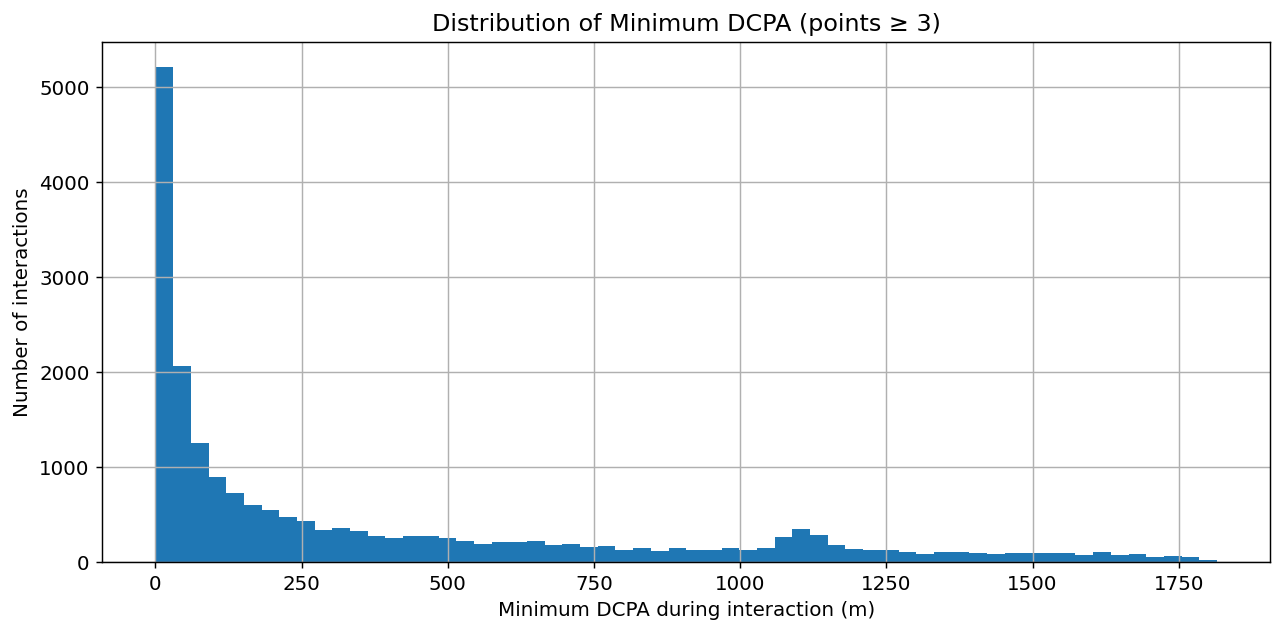

Saved: plots\01_min_dcpa_distribution.png
Count used (non-NaN): 20537
Clipped at (m): 2000
Max in data (m): 1815.461429230735


In [3]:
# =========================
# Plot 1: Distribution of minimum DCPA (interaction level)
# =========================

# Use visualization-filtered interactions only
dcpa = behavior_vis["min_dcpa_m"].dropna()

# Optional: clip extreme values so the histogram stays readable
# (keeps the plot focused on the dense region; does NOT change the underlying data)
DCPA_MAX_PLOT = 2000
dcpa_clip = dcpa.clip(upper=DCPA_MAX_PLOT)

plt.figure(figsize=(10, 5))
plt.hist(dcpa_clip, bins=60)
plt.xlabel("Minimum DCPA during interaction (m)")
plt.ylabel("Number of interactions")
plt.title(f"Distribution of Minimum DCPA (points ≥ {MIN_POINTS})")
plt.tight_layout()

out_path = os.path.join(PLOTS_DIR, "01_min_dcpa_distribution.png")
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)
print("Count used (non-NaN):", len(dcpa))
print("Clipped at (m):", DCPA_MAX_PLOT)
print("Max in data (m):", float(dcpa.max()))


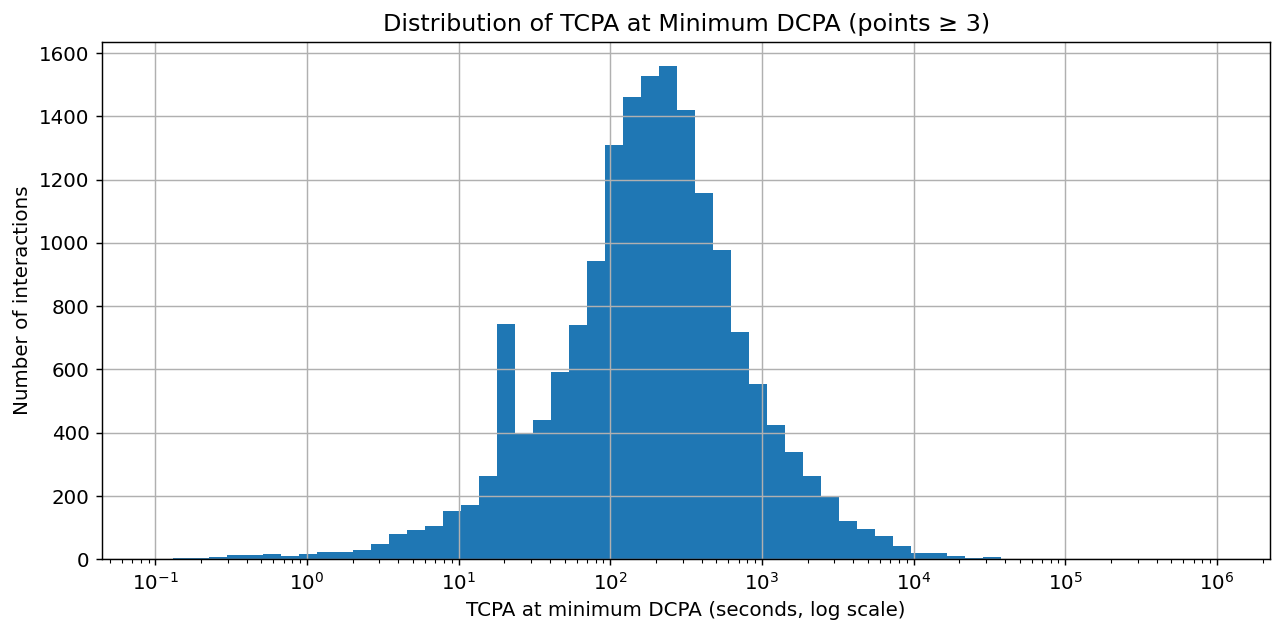

Saved: plots\02_tcpa_distribution.png
Count used (non-NaN): 20537
TCPA range (s): 0.0 → 508829.4343991087


In [4]:
# =========================
# Plot 2: Distribution of TCPA at minimum DCPA
# =========================

# Use visualization-filtered interactions only
tcpa = behavior_vis["tcpa_s"].dropna()

# TCPA must be >= 0 by definition
tcpa = tcpa[tcpa >= 0]

plt.figure(figsize=(10, 5))

# Log-spaced bins give a clean distribution without distortion
bins = np.logspace(-1, 6, 60)  # 0.1 s to ~11 days

plt.hist(tcpa, bins=bins)
plt.xscale("log")

plt.xlabel("TCPA at minimum DCPA (seconds, log scale)")
plt.ylabel("Number of interactions")
plt.title(f"Distribution of TCPA at Minimum DCPA (points ≥ {MIN_POINTS})")

plt.tight_layout()

out_path = os.path.join(PLOTS_DIR, "02_tcpa_distribution.png")
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)
print("Count used (non-NaN):", len(tcpa))
print("TCPA range (s):", float(tcpa.min()), "→", float(tcpa.max()))


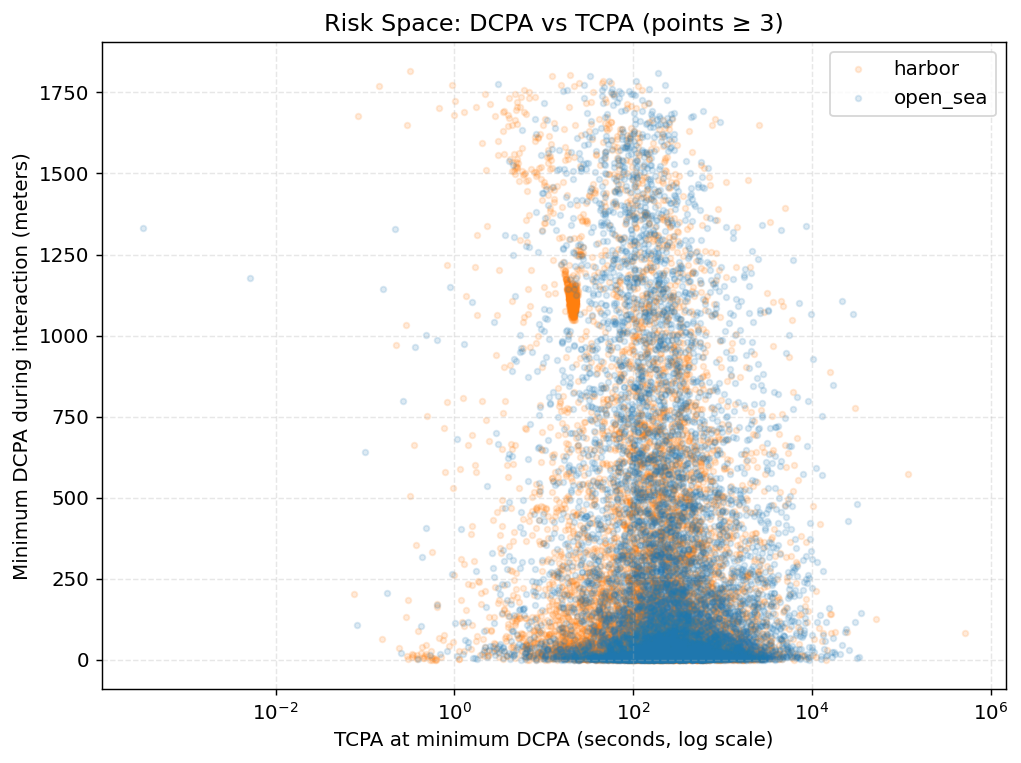

Saved: plots\03_risk_space_dcpa_tcpa.png
Points plotted: 20537


In [5]:
# =========================
# Plot 3: Risk space (DCPA vs TCPA), colored by region
# =========================

df = behavior_vis.dropna(subset=["min_dcpa_m", "tcpa_s"])

# TCPA must be non-negative
df = df[df["tcpa_s"] >= 0]

plt.figure(figsize=(8, 6))

for region, color in [("harbor", "tab:orange"), ("open_sea", "tab:blue")]:
    sub = df[df["region_type"] == region]
    plt.scatter(
        sub["tcpa_s"],
        sub["min_dcpa_m"],
        s=10,
        alpha=0.15,
        label=region,
        color=color
    )

plt.xscale("log")

plt.xlabel("TCPA at minimum DCPA (seconds, log scale)")
plt.ylabel("Minimum DCPA during interaction (meters)")
plt.title(f"Risk Space: DCPA vs TCPA (points ≥ {MIN_POINTS})")

plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.3)

plt.tight_layout()

out_path = os.path.join(PLOTS_DIR, "03_risk_space_dcpa_tcpa.png")
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)
print("Points plotted:", len(df))


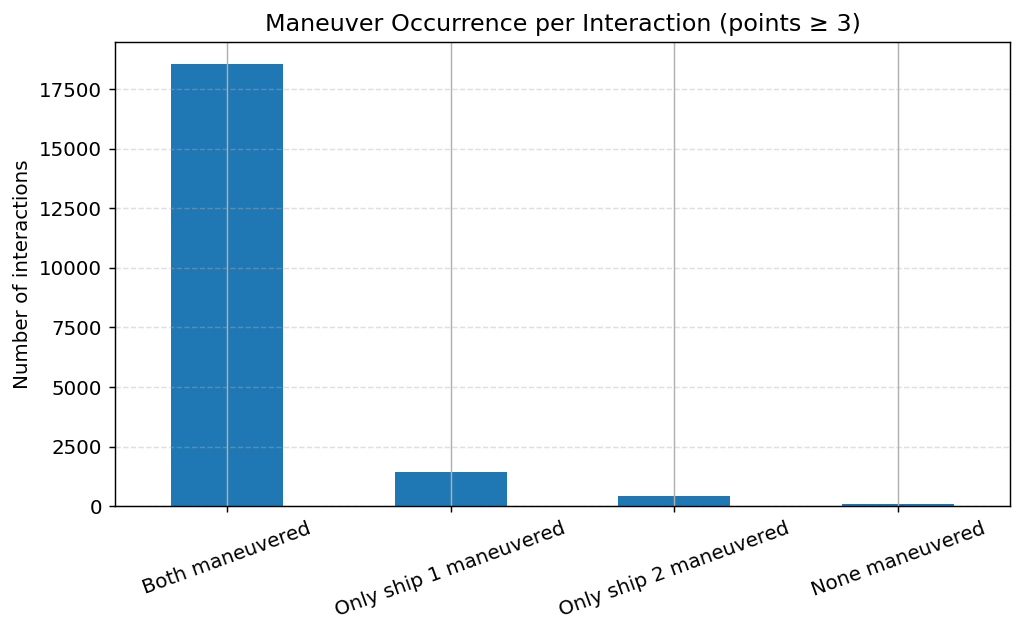

Saved: plots\04_maneuver_occurrence.png
Both maneuvered           18561
Only ship 1 maneuvered     1449
Only ship 2 maneuvered      429
None maneuvered              99
dtype: int64


In [6]:
# =========================
# Plot 4: Maneuver occurrence per interaction
# =========================

def maneuver_category(row):
    if row["maneuvered_1"] and row["maneuvered_2"]:
        return "Both maneuvered"
    if row["maneuvered_1"] and not row["maneuvered_2"]:
        return "Only ship 1 maneuvered"
    if not row["maneuvered_1"] and row["maneuvered_2"]:
        return "Only ship 2 maneuvered"
    return "None maneuvered"

cats = behavior_vis.apply(maneuver_category, axis=1)
counts = cats.value_counts().reindex([
    "Both maneuvered",
    "Only ship 1 maneuvered",
    "Only ship 2 maneuvered",
    "None maneuvered"
])

plt.figure(figsize=(8, 5))
counts.plot(kind="bar")

plt.ylabel("Number of interactions")
plt.title(f"Maneuver Occurrence per Interaction (points ≥ {MIN_POINTS})")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()

out_path = os.path.join(PLOTS_DIR, "04_maneuver_occurrence.png")
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)
print(counts)


<Figure size 910x650 with 0 Axes>

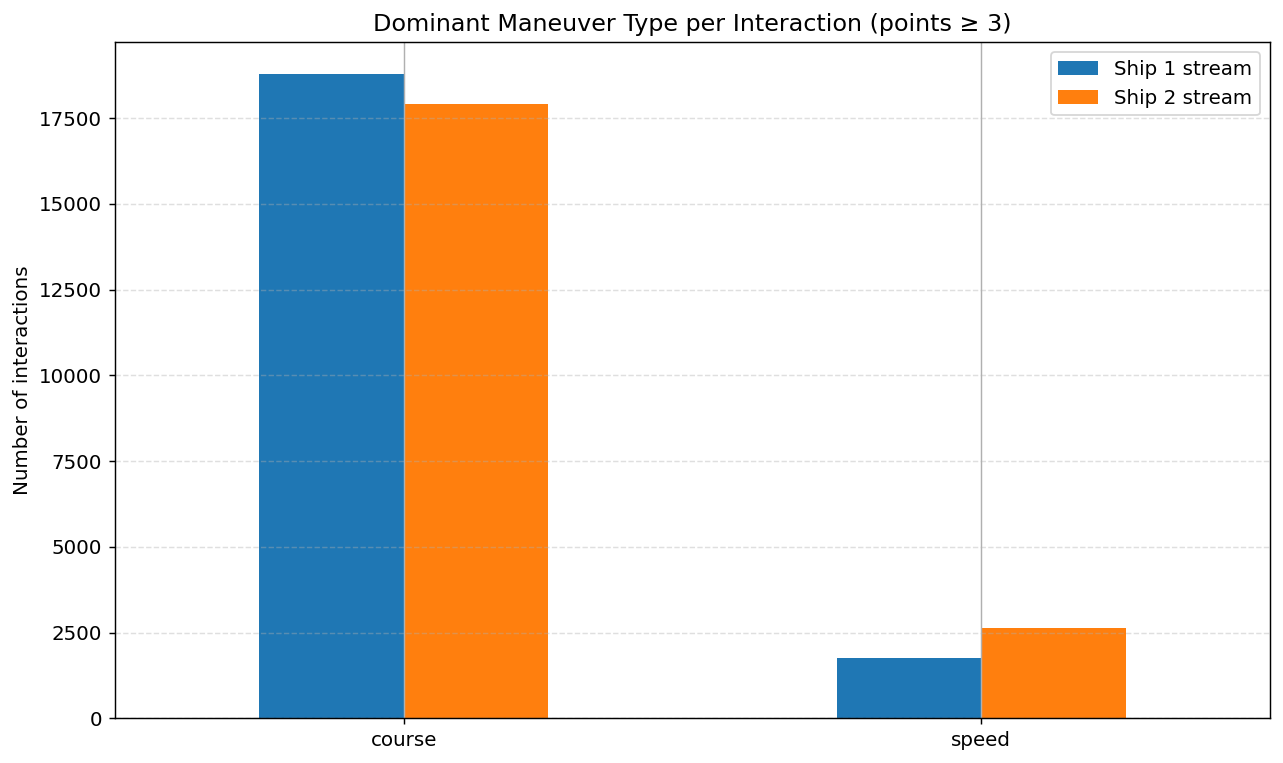

Saved: plots\05_dominant_maneuver_type.png
        Ship 1 stream  Ship 2 stream
course          18784          17910
speed            1754           2628


In [7]:
# =========================
# Plot 5: Dominant maneuver type (course vs speed)
# =========================

dom1 = behavior_vis["dominance_1"].value_counts().reindex(["course", "speed"])
dom2 = behavior_vis["dominance_2"].value_counts().reindex(["course", "speed"])

df_dom = pd.DataFrame({
    "Ship 1 stream": dom1,
    "Ship 2 stream": dom2
})

plt.figure(figsize=(7, 5))
df_dom.plot(kind="bar")

plt.ylabel("Number of interactions")
plt.title(f"Dominant Maneuver Type per Interaction (points ≥ {MIN_POINTS})")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()

out_path = os.path.join(PLOTS_DIR, "05_dominant_maneuver_type.png")
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)
print(df_dom)


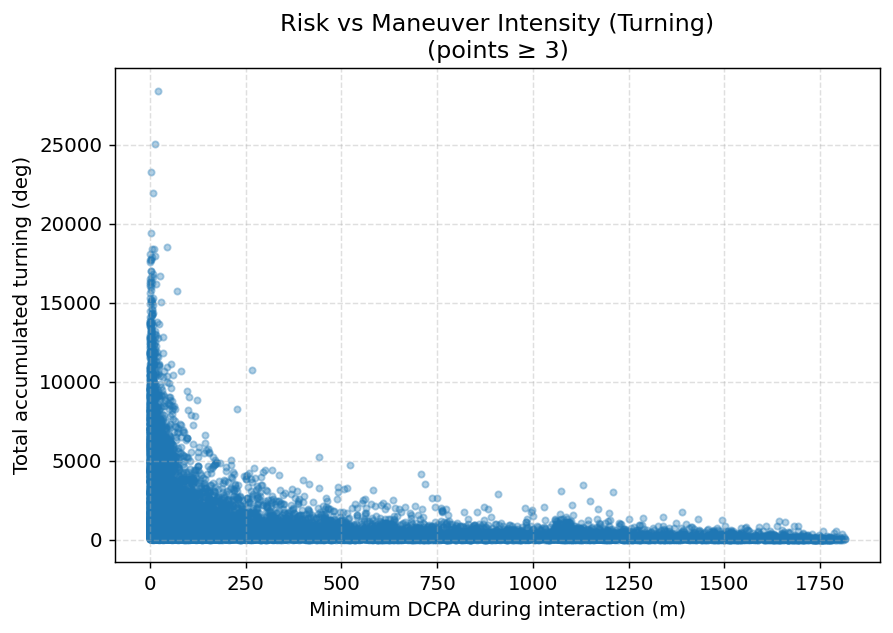

Saved: plots\06_risk_vs_turning.png


In [8]:
# =========================
# Plot 6: Risk vs maneuver intensity (turning)
# =========================

behavior_vis["total_turning_deg"] = (
    behavior_vis["total_turn_1_deg"] + behavior_vis["total_turn_2_deg"]
)

plt.figure(figsize=(7, 5))

plt.scatter(
    behavior_vis["min_dcpa_m"],
    behavior_vis["total_turning_deg"],
    s=12,
    alpha=0.35
)

plt.xlabel("Minimum DCPA during interaction (m)")
plt.ylabel("Total accumulated turning (deg)")
plt.title(f"Risk vs Maneuver Intensity (Turning)\n(points ≥ {MIN_POINTS})")

plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()

out_path = os.path.join(PLOTS_DIR, "06_risk_vs_turning.png")
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)


In [9]:
# =========================
# Plot 7: Select representative interaction cases (for trajectory plots)
# =========================

# --- High-risk: smallest min DCPA overall ---
high_risk = behavior_vis.dropna(subset=["min_dcpa_m"]).sort_values("min_dcpa_m").iloc[0]

# --- Typical: closest to median min DCPA ---
tmp = behavior_vis.dropna(subset=["min_dcpa_m"]).copy()
median_dcpa = tmp["min_dcpa_m"].median()
tmp["abs_from_median"] = (tmp["min_dcpa_m"] - median_dcpa).abs()
typical = tmp.sort_values("abs_from_median").iloc[0]

# --- Harbor: smallest min DCPA within harbor ---
harbor_df = behavior_vis[(behavior_vis["region_type"] == "harbor")].dropna(subset=["min_dcpa_m"])
harbor_case = harbor_df.sort_values("min_dcpa_m").iloc[0] if len(harbor_df) else None

cases = [
    ("high_risk", high_risk),
    ("typical", typical),
]
if harbor_case is not None:
    cases.append(("harbor_min_dcpa", harbor_case))

print("Selected interaction cases (from behavior_vis):\n")
for name, row in cases:
    print(f"[{name}] ship_low={int(row['ship_low'])}, ship_high={int(row['ship_high'])}, interaction_id={int(row['interaction_id'])}")
    print(f"  min_dcpa_m={row['min_dcpa_m']:.3f}, tcpa_s={row['tcpa_s']:.3f}, region={row['region_type']}, points={int(row['points_count'])}")
    print(f"  start={row['start_time']}, end={row['end_time']}")
    print()

# =========================
# Validation: make sure each selected case exists in classified_linked
# and the row count matches behavior_summary points_count
# =========================
print("\n--- Validation against classified_linked.csv ---\n")

for name, row in cases:
    ship_low = row["ship_low"]
    ship_high = row["ship_high"]
    interaction_id = row["interaction_id"]
    expected_points = int(row["points_count"])

    traj = classified[
        (classified["ship_low"] == ship_low) &
        (classified["ship_high"] == ship_high) &
        (classified["interaction_id"] == interaction_id)
    ].sort_values("time_window")

    ok = "✅" if len(traj) == expected_points else "❌"
    print(f"[{name}] extracted_rows={len(traj)} vs expected_points={expected_points} -> {ok}")


Selected interaction cases (from behavior_vis):

[high_risk] ship_low=227730220, ship_high=356101000, interaction_id=0
  min_dcpa_m=0.001, tcpa_s=24.631, region=open_sea, points=11
  start=2015-10-06 06:58:00, end=2015-10-06 07:08:00

[typical] ship_low=227635680, ship_high=228144000, interaction_id=26
  min_dcpa_m=156.242, tcpa_s=211.735, region=open_sea, points=31
  start=2016-03-20 19:14:00, end=2016-03-20 20:37:00

[harbor_min_dcpa] ship_low=228051000, ship_high=311027900, interaction_id=1
  min_dcpa_m=0.010, tcpa_s=626.875, region=harbor, points=33
  start=2015-11-09 16:37:00, end=2015-11-09 17:09:00


--- Validation against classified_linked.csv ---

[high_risk] extracted_rows=11 vs expected_points=11 -> ✅
[typical] extracted_rows=31 vs expected_points=31 -> ✅
[harbor_min_dcpa] extracted_rows=33 vs expected_points=33 -> ✅


C:\Users\HP\AppData\Local\Temp\ipykernel_4804\2651597638.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sc1, ax=ax)


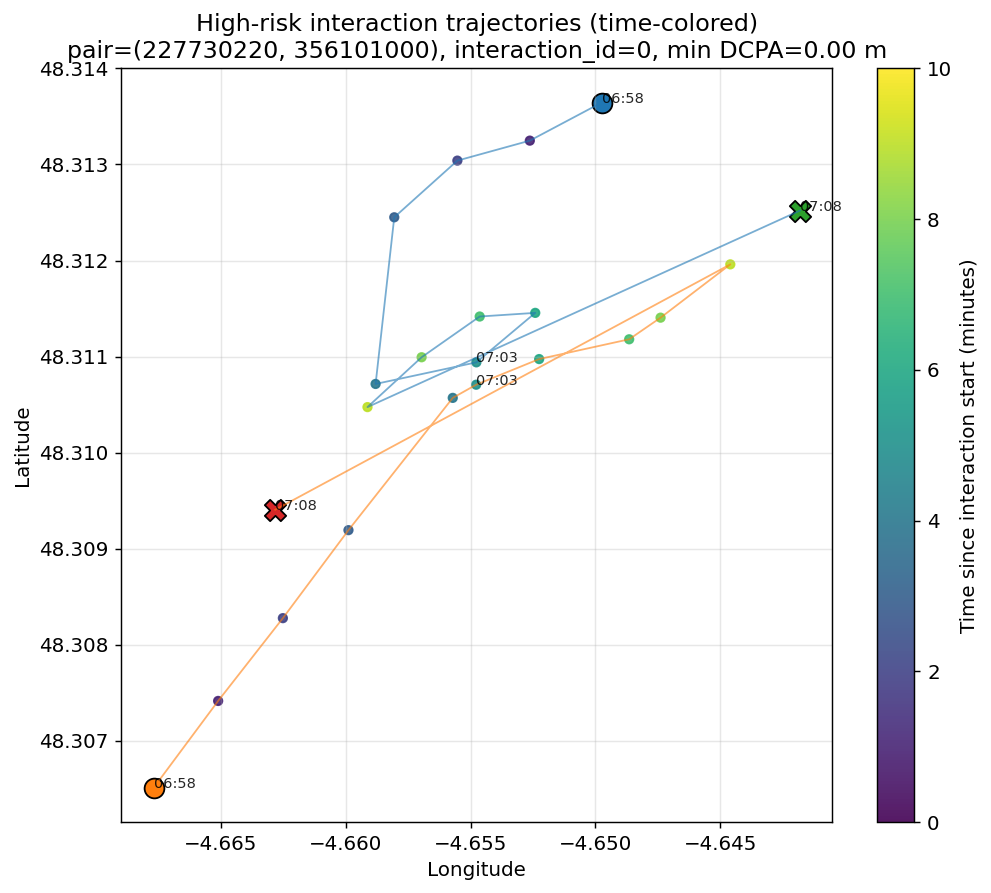

Saved: plots\08_high_risk_trajectories_time_colored.png


In [10]:
# =========================
# Plot 8: High-risk spatial trajectories (time gradient + timestamp markers)
# =========================

# Use the already-selected case from Plot 7
case_name = "high_risk"
row = high_risk  # from Plot 7

ship_low = row["ship_low"]
ship_high = row["ship_high"]
interaction_id = row["interaction_id"]

traj = classified[
    (classified["ship_low"] == ship_low) &
    (classified["ship_high"] == ship_high) &
    (classified["interaction_id"] == interaction_id)
].sort_values("time_window").reset_index(drop=True)

# Convert time to a numeric scale for gradient coloring
t0 = traj["time_window"].iloc[0]
traj["t_minutes"] = (traj["time_window"] - t0).dt.total_seconds() / 60.0

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 7))

# Plot faint connecting lines (keeps trajectory shape readable)
ax.plot(traj["lon_1"], traj["lat_1"], linewidth=1, alpha=0.6)
ax.plot(traj["lon_2"], traj["lat_2"], linewidth=1, alpha=0.6)

# Time gradient scatter (main readability feature)
sc1 = ax.scatter(traj["lon_1"], traj["lat_1"], c=traj["t_minutes"], s=22, alpha=0.9)
sc2 = ax.scatter(traj["lon_2"], traj["lat_2"], c=traj["t_minutes"], s=22, alpha=0.9)

cbar = plt.colorbar(sc1, ax=ax)
cbar.set_label("Time since interaction start (minutes)")

# Start / end markers
ax.scatter(traj["lon_1"].iloc[0], traj["lat_1"].iloc[0], s=120, marker="o", edgecolor="k")
ax.scatter(traj["lon_2"].iloc[0], traj["lat_2"].iloc[0], s=120, marker="o", edgecolor="k")

ax.scatter(traj["lon_1"].iloc[-1], traj["lat_1"].iloc[-1], s=140, marker="X", edgecolor="k")
ax.scatter(traj["lon_2"].iloc[-1], traj["lat_2"].iloc[-1], s=140, marker="X", edgecolor="k")

# Timestamp labels every N minutes (kept minimal)
LABEL_EVERY_MIN = 5
label_mask = (traj["t_minutes"] % LABEL_EVERY_MIN == 0)

for i in traj.index[label_mask]:
    ts = traj.loc[i, "time_window"].strftime("%H:%M")
    ax.text(traj.loc[i, "lon_1"], traj.loc[i, "lat_1"], ts, fontsize=8, alpha=0.85)
    ax.text(traj.loc[i, "lon_2"], traj.loc[i, "lat_2"], ts, fontsize=8, alpha=0.85)

# Title
ax.set_title(
    f"High-risk interaction trajectories (time-colored)\n"
    f"pair=({int(ship_low)}, {int(ship_high)}), interaction_id={int(interaction_id)}, "
    f"min DCPA={row['min_dcpa_m']:.2f} m"
)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, alpha=0.3)

# Save
plt.tight_layout()
# If you have a save helper:
# save_fig("08_high_risk_trajectories_time_colored.png")
# Otherwise:
plt.savefig(os.path.join(PLOTS_DIR, "08_high_risk_trajectories_time_colored.png"), dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", os.path.join(PLOTS_DIR, "08_high_risk_trajectories_time_colored.png"))


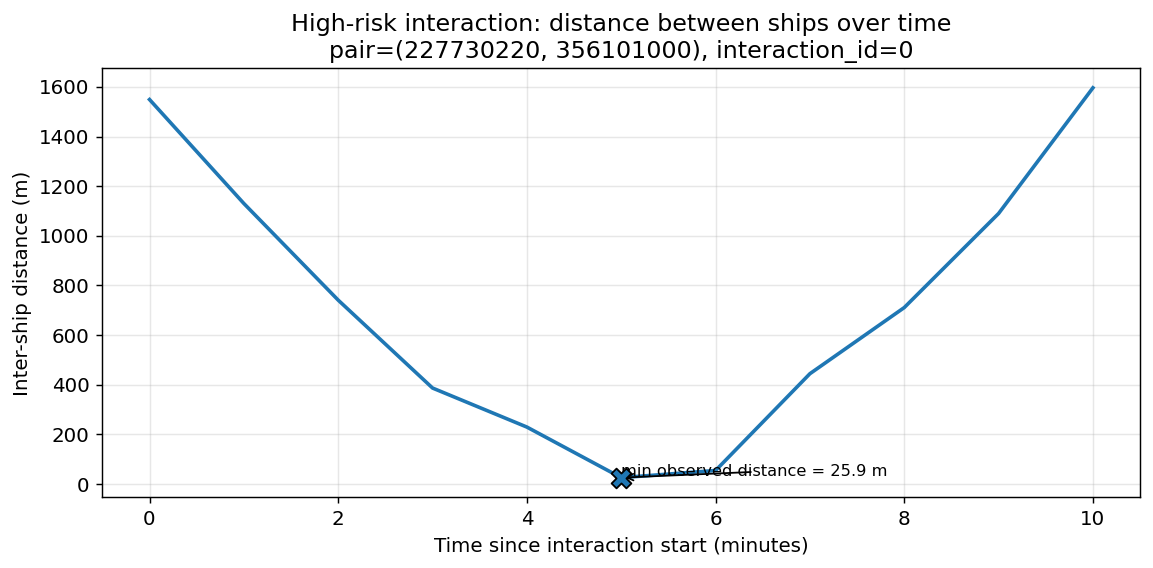

Saved: plots\09_high_risk_distance_over_time.png
Behavior summary min_dcpa_m = 0.000988 m (predicted CPA metric)
Trajectory min distance_m   = 25.916 m (observed at sampled timestamps)


In [11]:
# =========================
# Plot 9: High-risk distance over time
# =========================

# Use the already-selected high-risk case from Plot 7
row = high_risk

ship_low = row["ship_low"]
ship_high = row["ship_high"]
interaction_id = row["interaction_id"]

traj = classified[
    (classified["ship_low"] == ship_low) &
    (classified["ship_high"] == ship_high) &
    (classified["interaction_id"] == interaction_id)
].sort_values("time_window").reset_index(drop=True)

# Minutes since start (simple, readable x-axis)
t0 = traj["time_window"].iloc[0]
traj["t_minutes"] = (traj["time_window"] - t0).dt.total_seconds() / 60.0

# Find observed minimum distance in the extracted trajectory (not DCPA)
idx_min_dist = traj["distance_m"].idxmin()
t_min_dist = traj.loc[idx_min_dist, "t_minutes"]
min_dist = traj.loc[idx_min_dist, "distance_m"]

fig, ax = plt.subplots(figsize=(9, 4.5))

ax.plot(traj["t_minutes"], traj["distance_m"], linewidth=2)

# Marker for observed minimum distance
ax.scatter([t_min_dist], [min_dist], s=120, marker="X", edgecolor="k", zorder=5)

ax.set_title(
    "High-risk interaction: distance between ships over time\n"
    f"pair=({int(ship_low)}, {int(ship_high)}), interaction_id={int(interaction_id)}"
)
ax.set_xlabel("Time since interaction start (minutes)")
ax.set_ylabel("Inter-ship distance (m)")
ax.grid(True, alpha=0.3)

# Add a small annotation
ax.annotate(
    f"min observed distance = {min_dist:.1f} m",
    xy=(t_min_dist, min_dist),
    xytext=(t_min_dist, min_dist * 1.2 if min_dist > 0 else 50),
    arrowprops=dict(arrowstyle="->"),
    fontsize=9
)

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "09_high_risk_distance_over_time.png"), dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", os.path.join(PLOTS_DIR, "09_high_risk_distance_over_time.png"))
print(f"Behavior summary min_dcpa_m = {row['min_dcpa_m']:.6f} m (predicted CPA metric)")
print(f"Trajectory min distance_m   = {min_dist:.3f} m (observed at sampled timestamps)")


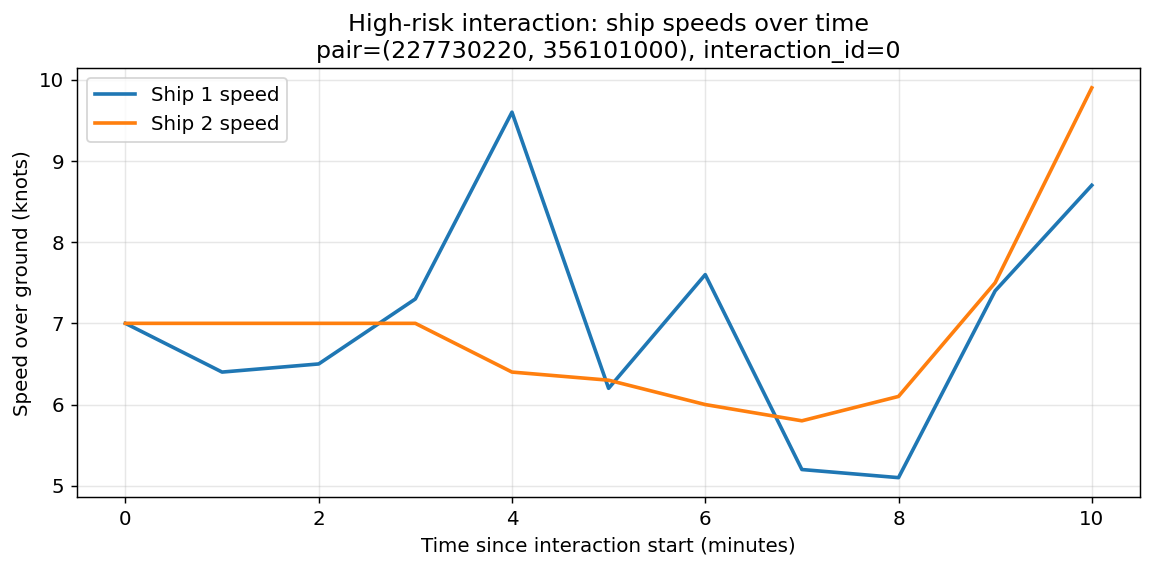

Saved: plots\10_high_risk_speeds_over_time.png


In [12]:
# =========================
# Plot 10: High-risk speeds over time
# =========================

fig, ax = plt.subplots(figsize=(9, 4.5))

ax.plot(
    traj["t_minutes"],
    traj["speed_1"],
    label="Ship 1 speed",
    linewidth=2
)

ax.plot(
    traj["t_minutes"],
    traj["speed_2"],
    label="Ship 2 speed",
    linewidth=2
)

ax.set_title(
    "High-risk interaction: ship speeds over time\n"
    f"pair=({int(ship_low)}, {int(ship_high)}), interaction_id={int(interaction_id)}"
)
ax.set_xlabel("Time since interaction start (minutes)")
ax.set_ylabel("Speed over ground (knots)")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(
    os.path.join(PLOTS_DIR, "10_high_risk_speeds_over_time.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()

print("Saved:", os.path.join(PLOTS_DIR, "10_high_risk_speeds_over_time.png"))


Typical interaction trajectory rows: 31


C:\Users\HP\AppData\Local\Temp\ipykernel_4804\3621742952.py:56: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sc1, ax=ax)


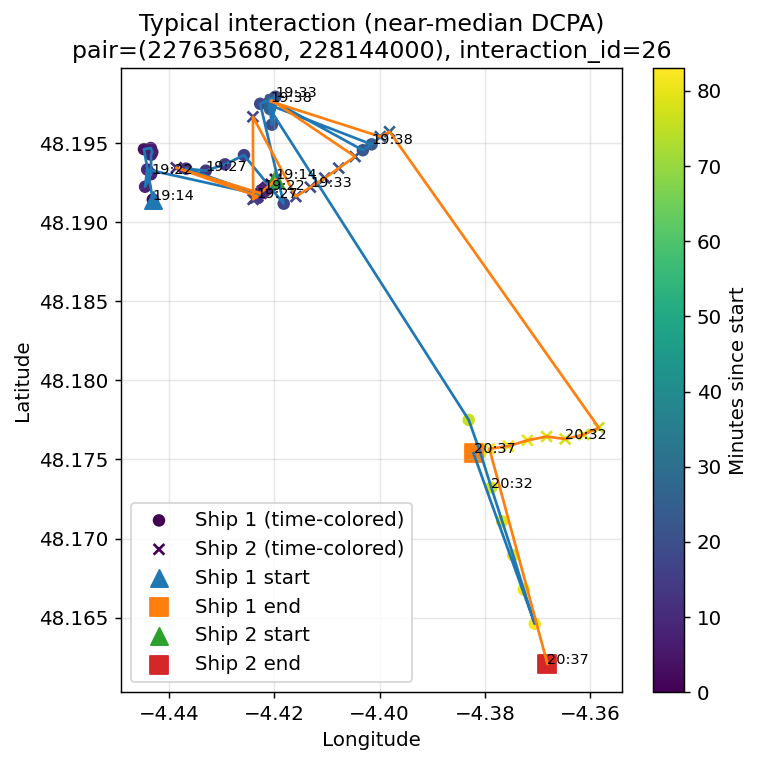

Saved: plots\11_typical_spatial_trajectories.png


In [15]:
# =========================
# Plot 11: Typical interaction trajectories (near-median DCPA)
#  - time gradient (minutes since start)
#  - timestamp labels (HH:MM) along both tracks
# =========================

# Use the previously selected "typical" interaction
ship_low = typical["ship_low"]
ship_high = typical["ship_high"]
interaction_id = typical["interaction_id"]

traj_typical = classified[
    (classified["ship_low"] == ship_low) &
    (classified["ship_high"] == ship_high) &
    (classified["interaction_id"] == interaction_id)
].sort_values("time_window").copy()

# Ensure datetime (safe even if already datetime)
traj_typical["time_window"] = pd.to_datetime(traj_typical["time_window"])

# Time in minutes since interaction start
traj_typical["t_minutes"] = (
    traj_typical["time_window"] - traj_typical["time_window"].iloc[0]
).dt.total_seconds() / 60.0

print("Typical interaction trajectory rows:", len(traj_typical))

fig, ax = plt.subplots(figsize=(6, 6))

# ---- Time gradient scatter + line (Ship 1) ----
sc1 = ax.scatter(
    traj_typical["lon_1"], traj_typical["lat_1"],
    c=traj_typical["t_minutes"],
    s=35,
    label="Ship 1 (time-colored)"
)
ax.plot(
    traj_typical["lon_1"], traj_typical["lat_1"],
    linewidth=1.5
)

# ---- Time gradient scatter + line (Ship 2) ----
sc2 = ax.scatter(
    traj_typical["lon_2"], traj_typical["lat_2"],
    c=traj_typical["t_minutes"],
    s=35,
    marker="x",
    label="Ship 2 (time-colored)"
)
ax.plot(
    traj_typical["lon_2"], traj_typical["lat_2"],
    linewidth=1.5
)

# Colorbar (minutes since start)
cbar = plt.colorbar(sc1, ax=ax)
cbar.set_label("Minutes since start")

# Start points (triangles) + End points (squares)
ax.scatter(traj_typical["lon_1"].iloc[0],  traj_typical["lat_1"].iloc[0],  s=90, marker="^", label="Ship 1 start")
ax.scatter(traj_typical["lon_1"].iloc[-1], traj_typical["lat_1"].iloc[-1], s=90, marker="s", label="Ship 1 end")
ax.scatter(traj_typical["lon_2"].iloc[0],  traj_typical["lat_2"].iloc[0],  s=90, marker="^", label="Ship 2 start")
ax.scatter(traj_typical["lon_2"].iloc[-1], traj_typical["lat_2"].iloc[-1], s=90, marker="s", label="Ship 2 end")

# ---- Timestamp labels along the paths (robust: index stepping, no modulo float bugs) ----
LABEL_EVERY_K_POINTS = max(1, len(traj_typical) // 6)  # ~6 labels total

for i in range(0, len(traj_typical), LABEL_EVERY_K_POINTS):
    r = traj_typical.iloc[i]
    ts = r["time_window"].strftime("%H:%M")
    ax.text(r["lon_1"], r["lat_1"], ts, fontsize=8)
    ax.text(r["lon_2"], r["lat_2"], ts, fontsize=8)

ax.set_title(
    "Typical interaction (near-median DCPA)\n"
    f"pair=({int(ship_low)}, {int(ship_high)}), interaction_id={int(interaction_id)}"
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.grid(True, alpha=0.3)
ax.legend(loc="best")

plt.tight_layout()
plt.savefig(
    os.path.join(PLOTS_DIR, "11_typical_spatial_trajectories.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()

print("Saved:", os.path.join(PLOTS_DIR, "11_typical_spatial_trajectories.png"))


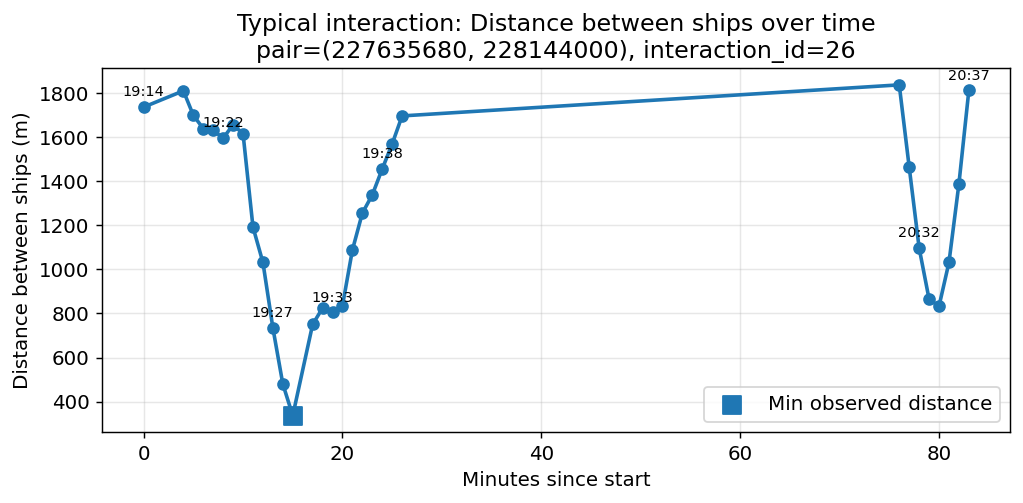

Saved: plots\12_typical_distance_over_time.png
Min observed distance = 336.8 m at t=15.0 min (2016-03-20 19:29)


In [16]:
# =========================
# Plot 12: Typical interaction — distance over time (with timestamps)
# =========================

# Reuse traj_typical from Plot 11
# traj_typical columns: time_window, distance_m, t_minutes

traj_typical = traj_typical.sort_values("time_window").copy()

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    traj_typical["t_minutes"],
    traj_typical["distance_m"],
    marker="o",
    linewidth=2
)

ax.set_title(
    "Typical interaction: Distance between ships over time\n"
    f"pair=({int(ship_low)}, {int(ship_high)}), interaction_id={int(interaction_id)}"
)
ax.set_xlabel("Minutes since start")
ax.set_ylabel("Distance between ships (m)")
ax.grid(True, alpha=0.3)

# Mark minimum distance point (closest observed separation)
i_min = traj_typical["distance_m"].idxmin()
t_min = traj_typical.loc[i_min, "t_minutes"]
d_min = traj_typical.loc[i_min, "distance_m"]
ts_min = traj_typical.loc[i_min, "time_window"].strftime("%Y-%m-%d %H:%M")
ax.scatter([t_min], [d_min], s=90, marker="s", label="Min observed distance")
ax.legend(loc="best")

# Timestamp labels along the curve (HH:MM)
LABEL_EVERY_K_POINTS = max(1, len(traj_typical) // 6)
for i in range(0, len(traj_typical), LABEL_EVERY_K_POINTS):
    r = traj_typical.iloc[i]
    ax.annotate(
        r["time_window"].strftime("%H:%M"),
        (r["t_minutes"], r["distance_m"]),
        textcoords="offset points",
        xytext=(0, 6),
        ha="center",
        fontsize=8
    )

plt.tight_layout()
plt.savefig(
    os.path.join(PLOTS_DIR, "12_typical_distance_over_time.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()

print("Saved:", os.path.join(PLOTS_DIR, "12_typical_distance_over_time.png"))
print(f"Min observed distance = {d_min:.1f} m at t={t_min:.1f} min ({ts_min})")


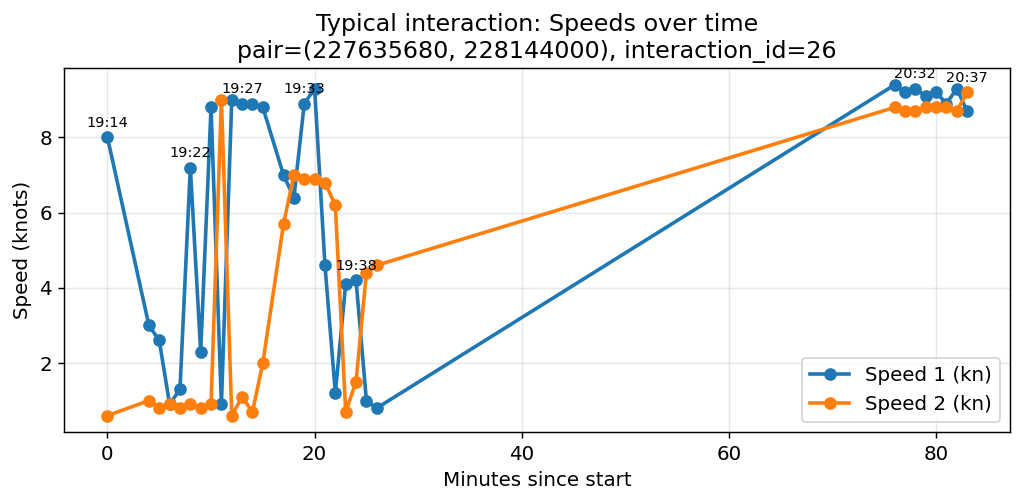

Saved: plots\13_typical_speeds_over_time.png


In [17]:
# =========================
# Plot 13: Typical interaction — speeds over time (with timestamps)
# =========================

# Reuse traj_typical from Plot 11/12 (assumes it already exists)
traj_typical = traj_typical.sort_values("time_window").copy()

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    traj_typical["t_minutes"],
    traj_typical["speed_1"],
    marker="o",
    linewidth=2,
    label="Speed 1 (kn)"
)
ax.plot(
    traj_typical["t_minutes"],
    traj_typical["speed_2"],
    marker="o",
    linewidth=2,
    label="Speed 2 (kn)"
)

ax.set_title(
    "Typical interaction: Speeds over time\n"
    f"pair=({int(ship_low)}, {int(ship_high)}), interaction_id={int(interaction_id)}"
)
ax.set_xlabel("Minutes since start")
ax.set_ylabel("Speed (knots)")
ax.grid(True, alpha=0.3)
ax.legend(loc="best")

# Timestamp labels along the x-axis (HH:MM) — annotate a few points
LABEL_EVERY_K_POINTS = max(1, len(traj_typical) // 6)
for i in range(0, len(traj_typical), LABEL_EVERY_K_POINTS):
    r = traj_typical.iloc[i]
    ax.annotate(
        r["time_window"].strftime("%H:%M"),
        (r["t_minutes"], max(r["speed_1"], r["speed_2"])),
        textcoords="offset points",
        xytext=(0, 6),
        ha="center",
        fontsize=8
    )

plt.tight_layout()
plt.savefig(
    os.path.join(PLOTS_DIR, "13_typical_speeds_over_time.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()

print("Saved:", os.path.join(PLOTS_DIR, "13_typical_speeds_over_time.png"))


Harbor interaction trajectory rows: 33


C:\Users\HP\AppData\Local\Temp\ipykernel_4804\779448035.py:77: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sc1, ax=ax)


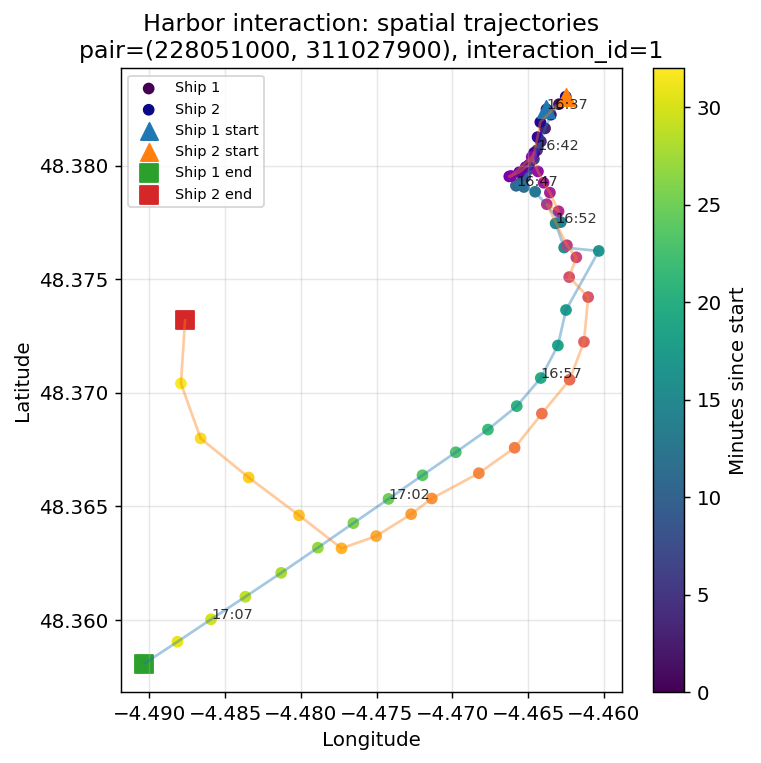

Saved: plots\14_harbor_spatial_trajectories.png


In [18]:
# =========================
# Plot 14: Harbor interaction — spatial trajectories (time gradient + timestamps)
# =========================

# Use the previously selected "harbor_min_dcpa" interaction
ship_low = harbor_case["ship_low"]
ship_high = harbor_case["ship_high"]
interaction_id = harbor_case["interaction_id"]

traj_harbor = classified[
    (classified["ship_low"] == ship_low) &
    (classified["ship_high"] == ship_high) &
    (classified["interaction_id"] == interaction_id)
].sort_values("time_window").copy()

# Time in minutes since interaction start
traj_harbor["t_minutes"] = (
    traj_harbor["time_window"] - traj_harbor["time_window"].iloc[0]
).dt.total_seconds() / 60.0

print("Harbor interaction trajectory rows:", len(traj_harbor))

fig, ax = plt.subplots(figsize=(6, 6))

# Time-colored trajectories
sc1 = ax.scatter(
    traj_harbor["lon_1"],
    traj_harbor["lat_1"],
    c=traj_harbor["t_minutes"],
    cmap="viridis",
    s=30,
    label="Ship 1"
)

sc2 = ax.scatter(
    traj_harbor["lon_2"],
    traj_harbor["lat_2"],
    c=traj_harbor["t_minutes"],
    cmap="plasma",
    s=30,
    label="Ship 2"
)

# Connect points with light lines
ax.plot(traj_harbor["lon_1"], traj_harbor["lat_1"], alpha=0.4)
ax.plot(traj_harbor["lon_2"], traj_harbor["lat_2"], alpha=0.4)

# Start and end markers
ax.scatter(
    traj_harbor["lon_1"].iloc[0], traj_harbor["lat_1"].iloc[0],
    marker="^", s=90, label="Ship 1 start"
)
ax.scatter(
    traj_harbor["lon_2"].iloc[0], traj_harbor["lat_2"].iloc[0],
    marker="^", s=90, label="Ship 2 start"
)
ax.scatter(
    traj_harbor["lon_1"].iloc[-1], traj_harbor["lat_1"].iloc[-1],
    marker="s", s=90, label="Ship 1 end"
)
ax.scatter(
    traj_harbor["lon_2"].iloc[-1], traj_harbor["lat_2"].iloc[-1],
    marker="s", s=90, label="Ship 2 end"
)

# Timestamp annotations (sparse)
LABEL_EVERY_K_POINTS = max(1, len(traj_harbor) // 6)
for i in range(0, len(traj_harbor), LABEL_EVERY_K_POINTS):
    r = traj_harbor.iloc[i]
    ax.annotate(
        r["time_window"].strftime("%H:%M"),
        (r["lon_1"], r["lat_1"]),
        fontsize=8,
        alpha=0.8
    )

cbar = plt.colorbar(sc1, ax=ax)
cbar.set_label("Minutes since start")

ax.set_title(
    "Harbor interaction: spatial trajectories\n"
    f"pair=({int(ship_low)}, {int(ship_high)}), interaction_id={int(interaction_id)}"
)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend(loc="best", fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(
    os.path.join(PLOTS_DIR, "14_harbor_spatial_trajectories.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()

print("Saved:", os.path.join(PLOTS_DIR, "14_harbor_spatial_trajectories.png"))


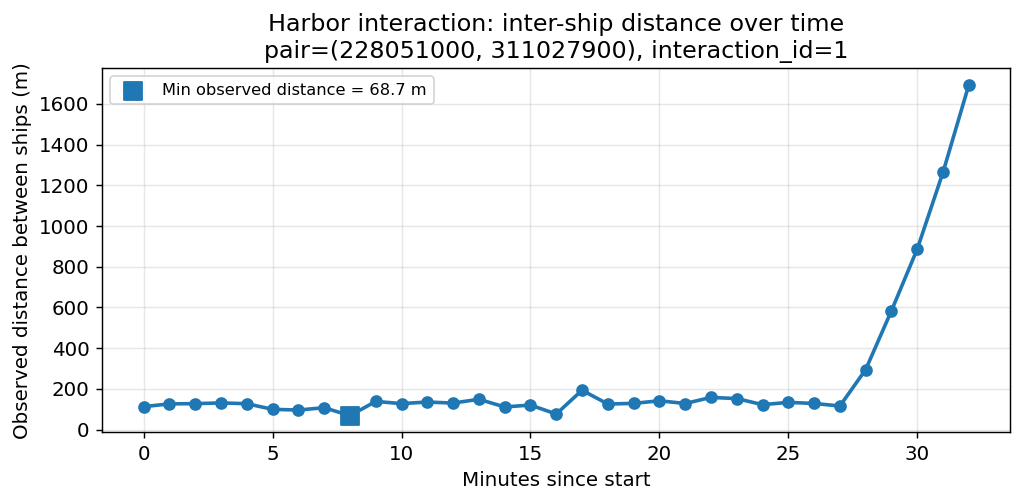

Saved: plots\15_harbor_distance_over_time.png


In [19]:
# =========================
# Plot 15: Harbor interaction — distance over time (with min DCPA marker)
# =========================

# Time axis
t0 = traj_harbor["time_window"].iloc[0]
traj_harbor["t_minutes"] = (traj_harbor["time_window"] - t0).dt.total_seconds() / 60.0

# Identify row of minimum instantaneous distance (not DCPA)
idx_min_dist = traj_harbor["distance_m"].idxmin()
min_dist_row = traj_harbor.loc[idx_min_dist]

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(traj_harbor["t_minutes"], traj_harbor["distance_m"], marker="o", linewidth=2)

# Mark closest observed distance point
ax.scatter(
    min_dist_row["t_minutes"],
    min_dist_row["distance_m"],
    marker="s",
    s=90,
    label=f"Min observed distance = {min_dist_row['distance_m']:.1f} m"
)

ax.set_title(
    "Harbor interaction: inter-ship distance over time\n"
    f"pair=({int(ship_low)}, {int(ship_high)}), interaction_id={int(interaction_id)}"
)
ax.set_xlabel("Minutes since start")
ax.set_ylabel("Observed distance between ships (m)")
ax.grid(True, alpha=0.3)
ax.legend(loc="best", fontsize=9)

plt.tight_layout()
plt.savefig(
    os.path.join(PLOTS_DIR, "15_harbor_distance_over_time.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()

print("Saved:", os.path.join(PLOTS_DIR, "15_harbor_distance_over_time.png"))


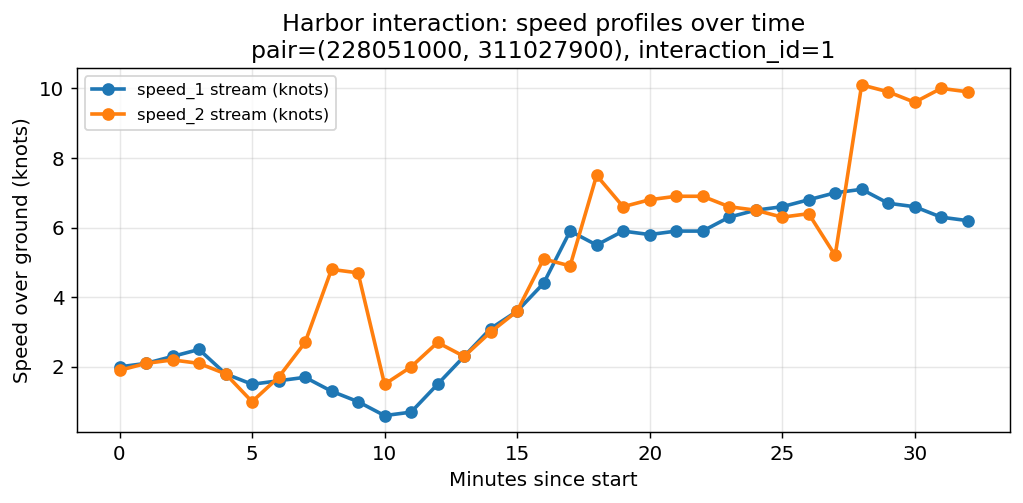

Saved: plots\16_harbor_speeds_over_time.png


In [20]:
# =========================
# Plot 16: Harbor interaction — speeds over time (both AIS streams)
# =========================

# Ensure time axis exists
if "t_minutes" not in traj_harbor.columns:
    t0 = traj_harbor["time_window"].iloc[0]
    traj_harbor["t_minutes"] = (traj_harbor["time_window"] - t0).dt.total_seconds() / 60.0

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(
    traj_harbor["t_minutes"],
    traj_harbor["speed_1"],
    marker="o",
    linewidth=2,
    label="speed_1 stream (knots)"
)

ax.plot(
    traj_harbor["t_minutes"],
    traj_harbor["speed_2"],
    marker="o",
    linewidth=2,
    label="speed_2 stream (knots)"
)

ax.set_title(
    "Harbor interaction: speed profiles over time\n"
    f"pair=({int(ship_low)}, {int(ship_high)}), interaction_id={int(interaction_id)}"
)
ax.set_xlabel("Minutes since start")
ax.set_ylabel("Speed over ground (knots)")
ax.grid(True, alpha=0.3)
ax.legend(loc="best", fontsize=9)

plt.tight_layout()
plt.savefig(
    os.path.join(PLOTS_DIR, "16_harbor_speeds_over_time.png"),
    dpi=300,
    bbox_inches="tight"
)
plt.show()

print("Saved:", os.path.join(PLOTS_DIR, "16_harbor_speeds_over_time.png"))


High-risk trajectory rows: 11


C:\Users\HP\AppData\Local\Temp\ipykernel_4804\1811225011.py:79: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(sc, ax=ax)


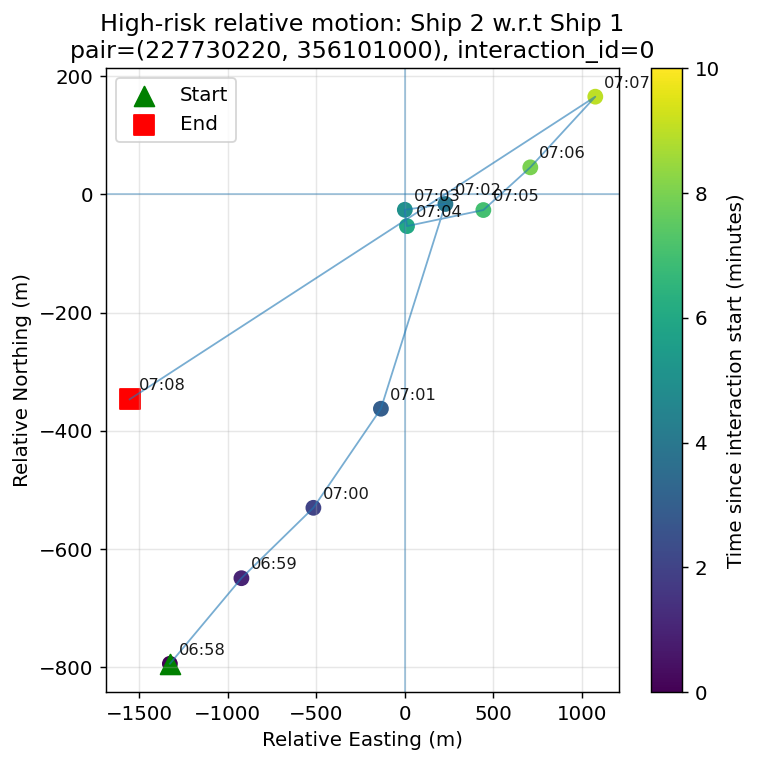

Saved: plots\17_high_risk_relative_motion.png


In [22]:
# =========================
# Plot 17: High-risk relative motion (Ship 2 w.r.t Ship 1)
# =========================
# Relative motion is plotted in a local tangent plane (meters):
# x = Easting, y = Northing, both measured from Ship 1 position at each timestamp.

# Use the already-selected "high_risk" interaction
ship_low = high_risk["ship_low"]
ship_high = high_risk["ship_high"]
interaction_id = high_risk["interaction_id"]

traj = classified[
    (classified["ship_low"] == ship_low) &
    (classified["ship_high"] == ship_high) &
    (classified["interaction_id"] == interaction_id)
].sort_values("time_window").copy()

print("High-risk trajectory rows:", len(traj))

# --- Compute relative position (Ship 2 - Ship 1) in meters ---
# Simple local approximation:
# 1 deg lat ≈ 111,320 m
# 1 deg lon ≈ 111,320 * cos(lat) m (use mean latitude for stability)
lat0 = traj["lat_1"].mean()
m_per_deg_lat = 111_320.0
m_per_deg_lon = 111_320.0 * np.cos(np.deg2rad(lat0))

traj["rel_x_m"] = (traj["lon_2"] - traj["lon_1"]) * m_per_deg_lon   # East
traj["rel_y_m"] = (traj["lat_2"] - traj["lat_1"]) * m_per_deg_lat   # North

# Time in minutes since start (for color gradient)
traj["t_minutes"] = (
    traj["time_window"] - traj["time_window"].iloc[0]
).dt.total_seconds() / 60.0

fig, ax = plt.subplots(figsize=(6, 6))

# Path + gradient points
ax.plot(traj["rel_x_m"], traj["rel_y_m"], linewidth=1, alpha=0.6)

sc = ax.scatter(
    traj["rel_x_m"],
    traj["rel_y_m"],
    c=traj["t_minutes"],
    cmap="viridis",
    s=60
)

# Start / end markers
ax.scatter(traj["rel_x_m"].iloc[0], traj["rel_y_m"].iloc[0],
           marker="^", s=120, color="green", label="Start")
ax.scatter(traj["rel_x_m"].iloc[-1], traj["rel_y_m"].iloc[-1],
           marker="s", s=120, color="red", label="End")

# Reference axes through origin (ship 1 position)
ax.axvline(0, linewidth=1, alpha=0.4)
ax.axhline(0, linewidth=1, alpha=0.4)

# Add timestamp labels (every k points to avoid clutter)
k = max(1, len(traj) // 6)  # ~6 labels total
for i in range(0, len(traj), k):
    ax.annotate(
        traj["time_window"].iloc[i].strftime("%H:%M"),
        (traj["rel_x_m"].iloc[i], traj["rel_y_m"].iloc[i]),
        textcoords="offset points",
        xytext=(5, 5),
        fontsize=9,
        alpha=0.9
    )

ax.set_title(
    "High-risk relative motion: Ship 2 w.r.t Ship 1\n"
    f"pair=({int(ship_low)}, {int(ship_high)}), interaction_id={int(interaction_id)}"
)
ax.set_xlabel("Relative Easting (m)")
ax.set_ylabel("Relative Northing (m)")
ax.grid(True, alpha=0.3)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Time since interaction start (minutes)")

ax.legend()
plt.tight_layout()

outpath = os.path.join(PLOTS_DIR, "17_high_risk_relative_motion.png")
plt.savefig(outpath, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", outpath)


----------------

## Results and Insights from Interaction Visualizations

This section summarizes the insights obtained from the visualization analysis of vessel–vessel interactions derived from AIS data. The results are based exclusively on the figures and outputs presented in this notebook (Plots 1–17), including both population-level statistics and detailed case studies.

---

### 1. Distribution of Interaction Risk Metrics

#### Minimum DCPA Distribution (Plot 1)

The distribution of minimum Distance at Closest Point of Approach (DCPA) shows a strong concentration of interactions at very small distances, with a long tail extending to larger separations. This indicates that, among interactions with at least three AIS points, close-proximity encounters are common, while higher DCPA interactions occur less frequently but still represent a substantial portion of the dataset.

The heavy density near low DCPA values suggests that many vessel pairs pass each other at relatively close range, emphasizing the importance of fine-scale interaction analysis rather than relying solely on coarse filtering thresholds.

---

#### TCPA at Minimum DCPA (Plot 2)

The distribution of Time to Closest Point of Approach (TCPA), evaluated at the moment of minimum DCPA, spans multiple orders of magnitude and is therefore visualized on a logarithmic scale.

Most interactions cluster at relatively short TCPA values, but the long right tail indicates that some interactions reach their minimum separation well after the interaction begins, particularly in low-speed or constrained environments. This highlights that minimum spatial risk does not necessarily coincide with short temporal horizons, and TCPA alone cannot be interpreted independently of DCPA.

---

### 2. Risk Space Structure: DCPA vs TCPA

#### Risk Space Visualization (Plot 3)

The joint distribution of minimum DCPA and TCPA reveals a structured risk space rather than a uniform cloud. Interactions populate a dense region characterized by small DCPA values combined with moderate TCPA, while sparser regions correspond to either large separations or very long time horizons.

When colored by operational context (harbor vs open sea), both environments overlap substantially in the risk space. However, harbor interactions tend to exhibit smaller DCPA values at comparable TCPA, consistent with navigational constraints and reduced maneuvering room. Open-sea interactions occupy a broader region, reflecting greater variability in encounter geometry and timing.

---

### 3. Maneuver Behavior Across Interactions

#### Maneuver Occurrence per Interaction (Plot 4)

The maneuver occurrence analysis shows that both vessels maneuvering during an interaction is the dominant outcome. Cases where only one vessel maneuvers are considerably less frequent, and interactions where neither vessel maneuvers are rare.

This suggests that vessel–vessel encounters are typically mutual processes, where both parties adjust behavior rather than a single vessel taking unilateral action.

---

#### Dominant Maneuver Type (Plot 5)

Across interactions, course changes dominate over speed changes for both vessel streams. Speed-only maneuvers are present but occur less frequently than course adjustments.

This result indicates that, within the observed AIS interactions, heading changes are the primary collision-avoidance mechanism, while speed modulation plays a secondary role. The symmetry between the two vessel streams further supports the interpretation of reciprocal maneuvering behavior.

---

#### Risk vs Maneuver Intensity (Turning) (Plot 6)

The relationship between minimum DCPA and accumulated turning reveals a clear pattern: lower DCPA interactions are associated with higher total turning angles, while interactions with larger minimum separation generally exhibit lower maneuver intensity.

Although variability exists, the overall trend indicates that increased collision risk elicits stronger course adjustments, consistent with navigational expectations. High turning intensity at very small DCPA values suggests reactive or late avoidance behavior in some encounters.

---

### 4. High-Risk Interaction Case Study

#### Spatial Trajectories and Distance Evolution (Plots 8 & 9)

The selected high-risk interaction (interaction_id = 0) exhibits trajectories that converge rapidly, reaching a very small observed minimum distance before diverging. The distance-over-time profile shows a sharp decrease followed by recovery, characteristic of a near-miss encounter.

The time-colored trajectories indicate that the closest approach occurs over a short temporal window, emphasizing the compressed decision horizon in high-risk scenarios.

---

#### Relative Motion Analysis (Plot 17)

The relative motion plot of Ship 2 with respect to Ship 1 provides a kinematic interpretation of the encounter. The trajectory progresses from large relative offsets toward the origin, passes near the closest-approach region, and then diverges.

This visualization confirms that the high-risk nature of the interaction arises from direct convergence in relative motion space, rather than from parallel or slowly diverging paths. The annotated timestamps demonstrate how relative geometry evolves continuously through the interaction.

---

#### Speed Profiles (Plot 10)

Speed profiles for the high-risk interaction show noticeable temporal variation in both vessels’ speeds, including periods of acceleration and deceleration. These changes align temporally with the approach and separation phases, indicating that speed adjustments complement course changes during high-risk avoidance.

---

### 5. Typical Interaction Case Study

#### Spatial and Temporal Characteristics (Plots 11–13)

The typical interaction (near-median DCPA, interaction_id = 26) displays a markedly different structure. Trajectories are more dispersed, and the distance-over-time curve shows a broader, smoother minimum, indicating a lower urgency encounter.

Speed profiles reveal gradual changes rather than abrupt maneuvers, suggesting anticipatory or low-stress navigation behavior. This interaction serves as a representative baseline against which high-risk encounters can be contrasted.

---

### 6. Harbor Interaction Case Study

#### Constrained Spatial Dynamics (Plots 14–16)

The harbor interaction (interaction_id = 1) is characterized by curved and channel-aligned trajectories, reflecting environmental constraints. Despite relatively low minimum distances, the distance-over-time curve remains stable for an extended duration before separation.

Speed profiles show generally lower speeds with moderate fluctuations, consistent with controlled maneuvering in confined waters. This demonstrates that low DCPA in harbor settings does not necessarily imply acute risk, as temporal and contextual factors strongly influence interaction severity.

---

### 7. Overall Insights

Taken together, these visualizations demonstrate that:

- Interaction risk emerges from the combined structure of DCPA, TCPA, and maneuver behavior, not from any single metric.
- Most interactions involve mutual maneuvering, dominated by course changes.
- High-risk encounters are distinguished by rapid convergence in relative motion space and concentrated maneuver responses.
- Typical and harbor interactions may exhibit low DCPA values but differ fundamentally in temporal evolution and maneuver intensity.

These findings justify the multi-level visualization approach adopted in this notebook and provide a comprehensive empirical foundation for subsequent modeling or classification of vessel interaction risk.
